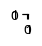

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import reconstruction_accuracy, VAELoss
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullFVAE
from src.datasets import CDR3BetaDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

# Some checks

In [394]:
%ls ../output/RedoTestKFOLD_readjustedWeights_rCSqS/RedoTestKFOLD_KFold_0_230927_1001_rCSqS

RedoTestKFOLD_KFold_0_230927_1001_rCSqS.png
args_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.txt
checkpoint_best_fold00_kcv_230921_nettcr_immrepnegs_noswap_f00_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.pt
train_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.pkl
train_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.pkl
valid_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.pkl
valid_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.pkl
valid_predictions_kcv_230921_nettcr_immrepnegs_noswap_f00_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.csv


In [396]:
for i in range(5):
    print(f'\n{i}')
    %cat ../output/RedoTestKFOLD_readjustedWeights_rCSqS/RedoTestKFOLD_KFold_{i}_230927_1001_rCSqS/args_RedoTestKFOLD_KFold_{i}_230927_1001_rCSqS.txt | tail -n 10


0
Best valid epoch: 1263
total:	0.15150960240612205
reconstruction:	0.1080471352777791
kld:	0.04346246641433629
seq_accuracy:	0.9669127464294434
v_accuracy:	0.993407130241394
j_accuracy:	0.99434894323349
Fold: 0Best valid seq acc: 0.9664827390245643
Best valid V acc: 0.9910525076524606
Best valid J acc: 0.9931716505768778

1
Best valid epoch: 1655
total:	0.12759196008296647
reconstruction:	0.08932886639228978
kld:	0.038263092472320674
seq_accuracy:	0.9610089063644409
v_accuracy:	0.9945805668830872
j_accuracy:	0.9964656233787537
Fold: 1Best valid seq acc: 0.9607527810908173
Best valid V acc: 0.9915174363807728
Best valid J acc: 0.9967012252591895

2
Best valid epoch: 817
total:	0.16030763908957424
reconstruction:	0.11644548907156406
kld:	0.043862149119377136
seq_accuracy:	0.9571055769920349
v_accuracy:	0.9926972985267639
j_accuracy:	0.9941107034683228
Fold: 2Best valid seq acc: 0.9562349613830535
Best valid V acc: 0.992226148409894
Best valid J acc: 0.9945818610129564

3
Best valid epo

In [50]:
for i in range(5):
    print(f'\n{i}')
    %cat ../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k/args_FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k.txt | tail -n 10


0
Fold: 0Best valid epoch: 575
total:	0.4113215639264493
reconstruction:	0.37363986051697323
kld:	0.037681700979748246
seq_accuracy:	0.9379920959472656
v_accuracy:	0.9218271970748901
j_accuracy:	0.99434894323349
Fold: 0Best valid seq acc: 0.9381558377693086
Best valid V acc: 0.9215917117965623
Best valid J acc: 0.993407110901813

1
Fold: 1Best valid epoch: 674
total:	0.6807788295862699
reconstruction:	0.6456284207852802
kld:	0.0351504118170354
seq_accuracy:	0.9561837315559387
v_accuracy:	0.8152686357498169
j_accuracy:	0.9957587122917175
Fold: 1Best valid seq acc: 0.9566856574804349
Best valid V acc: 0.819038642789821
Best valid J acc: 0.9957587181903864

2
Fold: 2Best valid epoch: 795
total:	0.7249003094413676
reconstruction:	0.6897032166819129
kld:	0.03519708667349759
seq_accuracy:	0.9577098488807678
v_accuracy:	0.8235571384429932
j_accuracy:	0.9955241680145264
Fold: 2Best valid seq acc: 0.9571465191206466
Best valid V acc: 0.8235571260306243
Best valid J acc: 0.9967020023557126

3
F

Probly don't need to have that much weight on J gene but for V gene 2.5 seems good.

In [33]:
%ls ../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k

FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.png
args_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.txt
checkpoint_best_fold00_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pt
train_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
train_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_predictions_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.csv


In [3]:
# init stuff
kcv_df = pd.read_csv('../data/filtered/230921_nettcr_immrepnegs_noswap.csv')
test_df = pd.read_csv('../data/filtered/230921_vdjdb_mcpas_filtered_concat_cdr3b_vjgenes')
# Re-init / write down params here ; Taken from the args.txt
max_len, encoding, pad_scale = 23, 'BL50LO', -20
cdr3b_col, v_col, j_col = 'B3', 'TRBV_gene', 'TRBJ_gene'
use_v, use_j, v_dim, j_dim = True, True, 51, 13
hidden_dim, latent_dim = 256, 128
lr, weight_decay = 5e-4, 1e-4
loss_weights = {'weight_seq':3, 'weight_kld':1, 'weight_v':2.5, 'weight_j':2}
n_epochs, batch_size = 2000, 256
# Remaking dataset-loaders
total_dataset = CDR3BetaDataset(kcv_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map=None, j_map = None)
total_loader = total_dataset.get_dataloader(batch_size, RandomSampler)
test_dataset = CDR3BetaDataset(kcv_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map= total_dataset.v_map, j_map = total_dataset.j_map)
test_loader = test_dataset.get_dataloader(batch_size, SequentialSampler)
folder = '../output/FirstTest_230926_1923_bb76k/'

In [ ]:
# Turns out, I didn't think that different partitions in the train dataset would have different v/j maps.
# As such, I need to save it here and reload it everytime (HARDCODED BAD BEHAVIOUR BUT NO WORKAROUND BECAUSE I NEED TO MAKE SURE THINGS MATCH BETWEEN FOLDS)
# Also need to fix the weights on seq/kld/v/j weights to 3, 2, 2.5, 1.5 ; For now, re-run the scripts and test stuff here and do inference.

In [44]:
pkl_dump(total_dataset.v_map, '../data/Matrices/230927_nettcr_dataset_vmap.pkl')
pkl_dump(total_dataset.j_map, '../data/Matrices/230927_nettcr_dataset_jmap.pkl')

/Users/riwa/Documents/code/tclustr/data/Matrices/230927_nettcr_dataset_vmap.pkl saved.
/Users/riwa/Documents/code/tclustr/data/Matrices/230927_nettcr_dataset_jmap.pkl saved.


# Reloading models and preds from KCV

In [45]:
models = {}
for i in range(5):
    fn = f'{folder}FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k/checkpoint_best_fold{i:02}_kcv_230921_nettcr_immrepnegs_noswap_f{i:02}_FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k.pt'
    try:
        models[i] = load_checkpoint(FullFVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)
    except:
        print(i)
        d = torch.load(fn)
        print(d['encoder.0.weight'].shape)
    # might as well retrain all folds with adjusted v/j/kld weights

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder_mu.weight', 'encoder_mu.bias', 'encoder_logvar.weight', 'encoder_logvar.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder_sequence.0.weight', 'decoder_sequence.0.bias', 'decoder_sequence.2.weight', 'decoder_sequence.2.bias', 'decoder_v.weight', 'decoder_v.bias', 'decoder_j.weight', 'decoder_j.bias'])
0
torch.Size([261, 523])
odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder_mu.weight', 'encoder_mu.bias', 'encoder_logvar.weight', 'encoder_logvar.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder_sequence.0.weight', 'decoder_sequence.0.bias', 'decoder_sequence.2.weight', 'decoder_sequence.2.bias', 'decoder_v.weight', 'decoder_v.bias', 'decoder_j.weight', 'decoder_j.bias'])
3
torch.Size([261, 523])


# Fixing the seq recons accuracy taking the pad instead of the actual sequence with the true lengths

In [72]:
sample = test_dataset.x[:5]
x_hat, _, _ = models[1](sample)


In [129]:
# Redo accuracy without padding
seq_true, v_true, j_true = models[1].reconstruct_hat(sample)
seq_hat, v_hat, j_hat = models[1].reconstruct_hat(x_hat)
# randomly change some indices so acc is not 100%
seq_hat[0,5:7]=3
seq_hat[1,6]=12
seq_hat[2, 0:7]=4

In [143]:
# NOTE : Fixed version with the true acc
def redo_acc(seq_true, seq_hat, v_true, v_hat, j_true, j_hat, pad_index=20, return_per_element=False):

    mask = (seq_true != pad_index).float()
    true_lens = mask.sum(dim=1)
    # masked_seq_true = seq_true*mask
    # masked_seq_hat = seq_hat*mask
    # difference here for per element is that we don't take the mean(dim=0) and have to detach() from graph to do tolist()
    seq_accuracy = ((seq_true == seq_hat).float() * mask).sum(1) / true_lens
    print(true_lens)
    print(mask)
    if return_per_element:
        seq_accuracy = seq_accuracy.detach().cpu().tolist()
        v_accuracy = ((v_true.argmax(dim=1) == v_hat.argmax(dim=1)).float()).detach().cpu().int().tolist()
        j_accuracy = ((j_true.argmax(dim=1) == j_hat.argmax(dim=1)).float()).detach().cpu().int().tolist()
    else:
        seq_accuracy = seq_accuracy.mean(dim=0).item()
        v_accuracy = ((v_true.argmax(dim=1) == v_hat.argmax(dim=1)).float().mean(dim=0)).item()
        j_accuracy = ((j_true.argmax(dim=1) == j_hat.argmax(dim=1)).float().mean(dim=0)).item()
    return seq_accuracy, v_accuracy, j_accuracy
redo_acc(seq_true, seq_hat, v_true, v_hat, j_true, j_hat, 20, True)[0]

tensor([10., 12., 13., 13., 13.])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])


[0.800000011920929, 0.9166666865348816, 0.38461539149284363, 1.0, 1.0]

In [109]:
((seq_true==seq_hat).float() * mask).sum(1) / true_lengths

tensor([0.8000, 0.9167, 0.3846, 1.0000, 1.0000])

In [107]:
# Create a binary mask where 1 indicates non-padding values
mask = (seq_true != 20).float()

# Sum along the columns to get the true length for each row
true_lengths = mask.sum(dim=1)
# Apply the mask to both seq_true and seq_hat
masked_seq_true = seq_true * mask
masked_seq_hat = seq_hat * mask

# Calculate element-wise equality
reconstruction_accuracy = ((masked_seq_true == masked_seq_hat).float() * mask).sum(1) / true_lengths
reconstruction_accuracy

tensor([0.8000, 0.9167, 0.3846, 1.0000, 1.0000])

In [97]:
true_lengths

tensor([10., 12., 13., 13., 13.])

# inference using the reloaded models (missing 2 folds) 230927_1009

## With V/J genes

In [200]:
%ls ../output/FirstTest_230926_1923_bb76k/

FirstTestKFOLD_bb76k_KFold_0_230927_1014_bb76k/
FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k/
FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k/
FirstTestKFOLD_bb76k_KFold_3_230927_1014_bb76k/
FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k/


In [205]:
next(filter(lambda x:'checkpoint' in x, os.listdir(fdir[0])))

'checkpoint_best_fold04_kcv_230921_nettcr_immrepnegs_noswap_f04_FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k.pt'

In [206]:
sorted(fdir)

['../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_0_230927_1014_bb76k/',
 '../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k/',
 '../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k/',
 '../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_3_230927_1014_bb76k/',
 '../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k/']

In [238]:
# reload all models now : 
maindir='../output/FirstTest_230926_1923_bb76k/'
fdirs = sorted([(f'{maindir}{x}'+'/').replace('//','/') for x in os.listdir(maindir) if x !='.DS_Store'])
models = {}
for i,fd in enumerate(fdirs):
    fn = f"{fd}{next(filter(lambda x:'checkpoint' in x, os.listdir(fd)))}"
    print(fn)
    models[i] = load_checkpoint(FullFVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)

../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_0_230927_1014_bb76k/checkpoint_best_fold00_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230927_1014_bb76k.pt
../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k/checkpoint_best_fold01_kcv_230921_nettcr_immrepnegs_noswap_f01_FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k.pt
../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k/checkpoint_best_fold02_kcv_230921_nettcr_immrepnegs_noswap_f02_FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k.pt
../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_3_230927_1014_bb76k/checkpoint_best_fold03_kcv_230921_nettcr_immrepnegs_noswap_f03_FirstTestKFOLD_bb76k_KFold_3_230927_1014_bb76k.pt
../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k/checkpoint_best_fold04_kcv_230921_nettcr_immrepnegs_noswap_f04_FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k.pt


In [247]:
from src.data_processing import AA_KEYS
test_df = pd.read_csv('../data/filtered/230921_vdjdb_mcpas_filtered_concat_cdr3b_vjgenes')
test_df['flag'] = test_df['B3'].apply(lambda x: all([c in AA_KEYS for c in x]))
# Some filtering that I forgot to do before...
test_df = test_df.query('flag')
test_df = test_df.query('TRBV_gene in @V_MAP.keys() and TRBJ_gene in @J_MAP.keys()')
test_df = test_df.query('B3 not in @kcv_df.B3.unique()')
# Re-saving the filtered test set
test_df.to_csv('../data/filtered/230927_vdjdb_mcpas_filtered_concat_REDONE_cdr3b_vjgenes.csv', index=False)
test_dataset = CDR3BetaDataset(test_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
test_loader = test_dataset.get_dataloader(1024, SequentialSampler)

In [240]:
from src.metrics import reconstruction_accuracy
from src.data_processing import V_MAP, J_MAP
from src.datasets import CDR3BetaDataset

df_valid_0 = kcv_df.query('partition==0')
valid_dataset_0 = CDR3BetaDataset(df_valid_0, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_0 = valid_dataset_0.get_dataloader(batch_size=1024, sampler=SequentialSampler)

df_valid_1 = kcv_df.query('partition==1')
valid_dataset_1 = CDR3BetaDataset(df_valid_1, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_1 = valid_dataset_1.get_dataloader(batch_size=1024, sampler=SequentialSampler)

df_valid_2 = kcv_df.query('partition==2')
valid_dataset_2 = CDR3BetaDataset(df_valid_2, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_2 = valid_dataset_2.get_dataloader(batch_size=1024, sampler=SequentialSampler)

df_valid_3 = kcv_df.query('partition==3')
valid_dataset_3 = CDR3BetaDataset(df_valid_3, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_3 = valid_dataset_3.get_dataloader(batch_size=1024, sampler=SequentialSampler)

df_valid_4 = kcv_df.query('partition==4')
valid_dataset_4 = CDR3BetaDataset(df_valid_4, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_4 = valid_dataset_4.get_dataloader(batch_size=1024, sampler=SequentialSampler)

# Re-get predictions so that we get the correct accuracy now with the updated non-pad seq reconstruction accuracy
torch.manual_seed(0)
df_valid_0 = predict_model(models[0], valid_dataset_0, valid_loader_0)
df_test_0 = predict_model(models[0], test_dataset, test_loader)
torch.manual_seed(1)
df_valid_1 = predict_model(models[1], valid_dataset_1, valid_loader_1)
df_test_1 = predict_model(models[1], test_dataset, test_loader)
torch.manual_seed(2)
df_valid_2 = predict_model(models[2], valid_dataset_2, valid_loader_2)
df_test_2 = predict_model(models[2], test_dataset, test_loader)
torch.manual_seed(3)
df_valid_3 = predict_model(models[3], valid_dataset_3, valid_loader_3)
df_test_3 = predict_model(models[3], test_dataset, test_loader)
torch.manual_seed(4)
df_valid_4 = predict_model(models[4], valid_dataset_4, valid_loader_4)
df_test_4 = predict_model(models[4], test_dataset, test_loader)

del valid_dataset_0, valid_loader_0, valid_dataset_1, valid_loader_1, valid_dataset_2, valid_loader_2, valid_dataset_3, valid_loader_3, valid_dataset_4, valid_loader_4, test_dataset, test_loader

In [243]:
for fd, valid, test in zip(fdirs, [df_valid_0, df_valid_1, df_valid_2, df_valid_3, df_valid_4], [df_test_0, df_test_1, df_test_2, df_test_3, df_test_4]):
    valid.to_csv(f'{fd}redo_valid.csv',index=False)
    test.to_csv(f'{fd}redo_test.csv',index=False)

In [391]:
model

FullFVAE(
  (encoder): Sequential(
    (0): Linear(in_features=524, out_features=262, bias=True)
    (1): SELU()
    (2): Linear(in_features=262, out_features=256, bias=True)
    (3): SELU()
  )
  (encoder_mu): Linear(in_features=256, out_features=128, bias=True)
  (encoder_logvar): Linear(in_features=256, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): SELU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SELU()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=256, out_features=262, bias=True)
    (1): SELU()
    (2): Linear(in_features=262, out_features=460, bias=True)
  )
  (decoder_v): Linear(in_features=256, out_features=51, bias=True)
  (decoder_j): Linear(in_features=256, out_features=13, bias=True)
)

In [244]:
for df, n in zip([df_valid_0, df_valid_1, df_valid_2, df_valid_3, df_valid_4, df_test_0, df_test_1, df_test_2, df_test_3, df_test_4],
                 ["z_valid_0", "z_valid_1", "z_valid_2", "z_valid_3", "z_valid_4", "z_test_0", "z_test_1", "z_test_2", "z_test_3", "z_test_4"]):
    print(n)
    print(f'Seq {df.seq_acc.mean():.2%}, V {df.v_correct.mean():.2%}, J {df.j_correct.mean():.2%}')


z_valid_0
Seq 91.40%, V 99.08%, J 99.34%
z_valid_1
Seq 92.90%, V 98.75%, J 99.62%
z_valid_2
Seq 93.22%, V 99.15%, J 99.69%
z_valid_3
Seq 92.27%, V 98.94%, J 99.22%
z_valid_4
Seq 91.89%, V 99.39%, J 99.03%
z_test_0
Seq 90.19%, V 98.12%, J 97.91%
z_test_1
Seq 91.48%, V 98.06%, J 98.38%
z_test_2
Seq 92.01%, V 98.46%, J 98.79%
z_test_3
Seq 90.86%, V 98.25%, J 98.11%
z_test_4
Seq 90.61%, V 98.44%, J 98.25%


In [245]:
# JUST DO THIS FOR NOW WITH THESE MODELS ; CHECK THE OTHER MODELS (REDO) later

## clustering stuff

In [5]:
from src.data_processing import V_MAP, J_MAP
kcv_df = pd.read_csv('../data/filtered/230921_nettcr_immrepnegs_noswap.csv')
# (top 10 + immrepnegs)
top11_pep = kcv_df.groupby(['peptide']).agg(count=('B3','count')).sort_values('count',ascending=False).head(11).index
top11_df = kcv_df.query('peptide in @top11_pep').reset_index(drop=True)
top11_dataset = CDR3BetaDataset(top11_df, max_len, encoding, pad_scale, cdr3b_col,  use_v, use_j, v_col, j_col, v_dim, j_dim, V_MAP, J_MAP)
top11_loader = top11_dataset.get_dataloader(1024, SequentialSampler)

### First, re-merge / process the kcv data to include CDR3 A and B from the raw files

In [343]:
%ls ../data/NetTCR

230919_nettcr_immrepnegs_merged_all.csv
230919_nettcr_immrepnegs_noswap.csv
95_redundancy_reduced_nettcr_train_mixed_negatives_ls_3_26_peptides_final.csv
anarci_annotated_new_df.csv
anarci_output.tsv
covid_controls/
negative_controls_95_redundancy_reduced.csv
nettcr_train_mathias.csv
new_train_df.csv


In [ ]:
# Annotation should come from Immrep and NetTCR/anarci_annotated_new_df

In [6]:
ndir = '../data/immrep/'
pos_annot = pd.read_csv('../data/NetTCR/anarci_output.tsv', sep = '\t')
neg_annot = pd.concat([pd.read_csv(f'{ndir}{f}', sep = '\t') for f in os.listdir(ndir)])[['TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'TRA_CDR3', 'TRB_CDR3']]


In [7]:
kcv_df

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,TRAJ,TRBV,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene
0,NSASDY,IRSNMDK,AERPGGKLI,SGHAT,FQNNGV,ASSYQGNEAF,0,immrep_negs,immrep_negs,TRAV13-2*01,TRAJ23*01,TRBV11-2*01,TRBJ1-1*01,3,NaN,NaN,immrep,NaN,TRBV11-2,TRBJ1-1
1,TISGNEY,GLKNN,IVRVGGSQGNLI,DFQATT,SNEGSKA,SARGPATNEKLF,0,immrep_negs,immrep_negs,TRAV26-1*01,TRAJ42*01,TRBV20-1*01,TRBJ1-4*01,2,NaN,NaN,immrep,NaN,TRBV20-1,TRBJ1-4
2,TRDTTYY,RNSFDEQN,ALSDPALKAAGNKLT,MNHEY,SMNVEV,ASSFFSGGWNEQF,0,immrep_negs,immrep_negs,TRAV19*01,TRAJ17*01,TRBV27*01,TRBJ2-1*01,4,NaN,NaN,immrep,NaN,TRBV27,TRBJ2-1
3,TSENNYY,QEAYKQQN,AFMNPNYQLI,SGDLS,YYNGEE,ASSAPDRPGNEQY,0,immrep_negs,immrep_negs,TRAV38-1*01,TRAJ33*01,TRBV9*01,TRBJ2-7*01,1,NaN,NaN,immrep,NaN,TRBV9,TRBJ2-7
4,YGGTVN,YFSGDPLV,LRGLDTGFQKLV,SGDLS,YYNGEE,ASSPYRDSQETQY,0,immrep_negs,immrep_negs,TRAV8-1*01,TRAJ8*01,TRBV9*01,TRBJ2-5*01,3,NaN,NaN,immrep,NaN,TRBV9,TRBJ2-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21212,TSENNYY,QEAYKQQN,AFMLGAGGTSYGKLT,LNHDA,SHIVND,ASSIGYYGYT,1,GILGFVFTL,GILGFVFTL,TRAV38-1*01,TRAJ52*01,TRBV19*02,TRBJ1-2*01,4,36260.0,HLA-A*02:01,VDJdb,2580.0,TRBV19,TRBJ1-2
21213,DSASNY,IRSNVGE,AYGGSQGNLI,LNHDA,SQIVND,ASSFRSSETQY,1,GILGFVFTL,GILGFVFTL,TRAV13-1*01,TRAJ42*01,TRBV19*01,TRBJ2-5*01,2,36817.0,HLA-A*02:01,10x,5082.0,TRBV19,TRBJ2-5
21214,NSASDY,IRSNMDK,AENLGGGSQGNLI,LNHDA,SQIVND,ASSTRATGELF,1,GILGFVFTL,GILGFVFTL,TRAV13-2*01,TRAJ42*01,TRBV19*01,TRBJ2-2*01,3,36884.0,HLA-A*02:01,10x,6211.0,TRBV19,TRBJ2-2
21215,SSVSVY,YLSGSTLV,AVGGDGGSQGNLI,LNHDA,SQIVND,ASSIRASGVEQF,1,GILGFVFTL,GILGFVFTL,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,2,37310.0,HLA-A*02:01,VDJdb,4078.0,TRBV19,TRBJ2-1


In [8]:
kcv_positives = kcv_df.query('origin!= "immrep"').merge(pos_annot[['A1', 'A2', 'A3', 'B1','B2','B3', 'TRA_CDR3', 'TRB_CDR3']], 
                                                        left_on=['A1', 'A2', 'A3', 'B1','B2','B3'], right_on=['A1', 'A2', 'A3', 'B1','B2','B3']).drop_duplicates(subset=['A1', 'A2', 'A3', 'B1','B2','B3'])
kcv_negatives = kcv_df.query('origin== "immrep"').merge(neg_annot[['A1', 'A2', 'A3', 'B1','B2','B3', 'TRA_CDR3', 'TRB_CDR3']], 
                                                        left_on=['A1', 'A2', 'A3', 'B1','B2','B3'], right_on=['A1', 'A2', 'A3', 'B1','B2','B3']).drop_duplicates(subset=['A1', 'A2', 'A3', 'B1','B2','B3'])
kcv_reannotated = pd.concat([kcv_positives, kcv_negatives])

kcv_reannotated['TRAV_gene'] = kcv_reannotated['TRAV'].apply(lambda x: x.split('*')[0].split(':')[0].split('/')[0])
kcv_reannotated['TRAJ_gene'] = kcv_reannotated['TRAJ'].apply(lambda x: x.split('*')[0].split(':')[0].split('/')[0])


kcv_reannotated.to_csv('../data/filtered/230927_nettcr_immrepnegs_noswap_ANNOTATED_CDR3.csv', index=False)
kcv_positives.to_csv('../data/filtered/230927_nettcr_positives_only.csv', index=False)

In [9]:
# Save for GLIPH 2:
import random
kcv_reannotated['count'] = 1 #kcv_reannotated['peptide'].apply(lambda x: 
kcv_reannotated['subj_cdt'] = kcv_reannotated['peptide'].apply(lambda x: f'{random.randint(0,99):02}/{random.randint(0, 9999):04}:{x}')
kcv_reannotated[['TRB_CDR3', 'TRBV_gene', 'TRBJ_gene', 'TRA_CDR3', 'subj_cdt','count']].to_csv('../data/kcv_to_GLIPH.tsv', index=False,header=False, sep='\t')

In [421]:
kcv_reannotated.to_csv('../data/kcv_to_GLIPH_annotated.csv', index=False)
kcv_reannotated.query('binder==1').to_csv('../data/kcv_to_GLIPH_BINDERS_annotated.csv', index=False)
kcv_reannotated.query('binder==1')[['TRB_CDR3', 'TRBV_gene', 'TRBJ_gene', 'TRA_CDR3', 'subj_cdt','count']].to_csv('../data/kcv_to_GLIPH_BINDERS.tsv', index=False,header=False, sep='\t')

In [403]:
model_novj = FullFVAE(23,'BL50LO', pad_scale=-20, use_v=False, use_j=False)

In [416]:
kcv_positives['TRB_CDR3'].apply(len).max()

25

## GLIPH results

In [12]:
# Reload annotations:

gliph_all_annot = pd.read_csv('../data/GLIPH/save_to_gliph/kcv_to_gliph_annotated.csv')
gliph_pep_annot = pd.read_csv('../data/GLIPH/save_to_gliph/kcv_to_GLIPH_BINDERS_annotated.csv')
gliph_results_all = pd.read_csv('../data/GLIPH/gliph_results/P10622_BCNXUMRLJM.csv')
gliph_results_all.drop(columns = [x for x in gliph_results_all.columns if 'HLA' in x], inplace=True)
gliph_results_all.head()

,index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,ulTcRb,TcRb,V,J,TcRa,Sample,Freq
0,1,SIRS,0.0,156,46,1.500000e-11,1.0,0.001,1.0,0.001,0.000015,motif-SIRS,CASSIrsldIQYF,CASSIRSLDIQYF,TRBV19,TRBJ2-4,CAGTYGGSQGNLIF,75/5473:GILGFVFTL,1.0
1,1,SIRS,0.0,156,46,1.500000e-11,1.0,0.001,1.0,0.001,0.000015,motif-SIRS,CASSIrSGNTEAF,CASSIRSGNTEAF,TRBV19,TRBJ1-1,CSPVGDGGSQGNLIF,70/9998:GILGFVFTL,1.0
2,1,SIRS,0.0,156,46,1.500000e-11,1.0,0.001,1.0,0.001,0.000015,motif-SIRS,CASSIrssNEQFF,CASSIRSSNEQFF,TRBV19,TRBJ2-1,CVVNYGGGSQGNLIF,37/7357:GILGFVFTL,1.0
3,1,SIRS,0.0,156,46,1.500000e-11,1.0,0.001,1.0,0.001,0.000015,motif-SIRS,CASSIrssETQYF,CASSIRSSETQYF,TRBV19,TRBJ2-5,CAVTRDDKIIF,05/2555:GILGFVFTL,1.0
4,1,SIRS,0.0,156,46,1.500000e-11,1.0,0.001,1.0,0.001,0.000015,motif-SIRS,CASSIrssETQYF,CASSIRSSETQYF,TRBV19,TRBJ2-5,CAAKSNTGKLIF,03/9283:GILGFVFTL,1.0


In [13]:
%ls ../output/

DEBUG_INIT_KFold_0_230926_1652_15lYT/
DEBUG_INIT_noV_noJ_KFold_0_230927_1553_None/
FirstTest_230926_1923_bb76k/
OnlyPositivesFullCDR3b_LowerDim_32_KFold_0_230927_1603_Yjqdd/
OnlyPositivesFullCDR3b_LowerDim_32_KFold_1_230927_1603_Yjqdd/
OnlyPositivesFullCDR3b_LowerDim_32_KFold_2_230927_1603_Yjqdd/
OnlyPositivesFullCDR3b_LowerDim_32_KFold_3_230927_1603_Yjqdd/
OnlyPositivesFullCDR3b_LowerDim_32_KFold_4_230927_1603_Yjqdd/
OnlyPositivesFullCDR3b_LowerDim_64_KFold_0_230927_1600_GqV0i/
OnlyPositivesFullCDR3b_LowerDim_64_KFold_1_230927_1600_GqV0i/
OnlyPositivesFullCDR3b_LowerDim_64_KFold_2_230927_1600_GqV0i/
OnlyPositivesFullCDR3b_LowerDim_64_KFold_3_230927_1600_GqV0i/
OnlyPositivesFullCDR3b_LowerDim_64_KFold_4_230927_1600_GqV0i/
RedoTestKFOLD_readjustedWeights_rCSqS/
notebooks/


## Results of training with CDR3b only

In [40]:
%ls ../output

230928_NotebookTests/
DEBUG_INIT_KFold_0_230926_1652_15lYT/
DEBUG_INIT_noV_noJ_KFold_0_230927_1553_None/
FirstTest_230926_1923_bb76k/
OnlyPosCDR3b_latent_64_wd_1e-3/
OnlyPosCDR3b_latent_64_wd_1e-4/
RedoTestKFOLD_readjustedWeights_rCSqS/
notebooks/


In [61]:
df['TRB_CDR3'].to_csv('../data/filtered/230928_NetTCR_CDR3B_pep.txt', index=False,header=False)

In [135]:
maindir

'../output/OnlyPosB3_latent_32_wd_1e-5_230928_1224_SY897/'

In [ ]:
maindirs = ['OnlyPosB3_latent_32_wd_1e-4_230928_1224_bYtbj', 'OnlyPosB3_latent_32_wd_1e-5_230928_1224_SY897', 'OnlyPosB3_latent_64_wd_1e-5_230928_1224_2Fxn5', 'OnlyPosCDR3b_latent_64_wd_1e-3_230928_1052_ouVRO', 'OnlyPosCDR3b_latent_64_wd_1e-4_230928_1052_QXmAq']
maindirs = ['../output/'+x+'/' for x in maindirs]
for maindir in maindirs:
    # reload all models now : 
    fdirs = sorted([(f'{maindir}{x}'+'/').replace('//','/') for x in os.listdir(maindir) if x !='.DS_Store' and os.path.isdir(f'{maindir}/{x}/')])
    max_len, encoding, pad_scale = 25, 'BL50LO', -20
    use_v, use_j, v_dim, j_dim = False, False, 0, 0 
    models = {}
    for i,fd in enumerate(fdirs):
        try:
            fn = f"{fd}{next(filter(lambda x:'checkpoint' in x, os.listdir(fd)))}"
        except:
            continue
        latent_dim = 32 if '32' in fn else 64 if '64' in fn else 128
        hidden_dim = 2*latent_dim
        print(fn)
        models[i] = load_checkpoint(FullFVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)
        
    df = kcv_positives.reset_index(drop=True)
    dataset = CDR3BetaDataset(df, max_len, encoding, pad_scale, cdr3b_col='B3', use_v=False, use_j=False, v_dim=0, j_dim=0)
    loader = dataset.get_dataloader(batch_size=1024, sampler=SequentialSampler)
    
    for fold, model in tqdm(models.items()):
        train_idx = df.query('partition!=@fold').index
        valid_idx = df.query('partition==@fold').index
        
        preds = predict_model(model, dataset, loader)
        train_preds = preds.loc[train_idx]
        valid_preds = preds.loc[valid_idx]
        z_train = train_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_train = train_preds['peptide'].values
        z_valid = valid_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_valid = valid_preds['peptide'].values
        km = KMeans(n_clusters=26, random_state=13)
        print('KM')
        train_clusters = km.fit_predict(z_train)
        valid_clusters = km.predict(z_valid)
        print('TSNE')
        tsne = TSNE(n_components=2, metric='l2', perplexity=25)
        # tsne = UMAP(n_components=2, learning_rate=0.1, metric='cosine', output_metric='cosine')
        
        latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
        tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]
        
        print('Making DFs')
        train_plot_df = pd.DataFrame(data=np.stack([tsne_train[:,0], tsne_train[:, 1], train_clusters, labels_train]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        train_plot_df['KMeans_Cluster'] = train_plot_df['KMeans_Cluster'].astype(str)
        valid_plot_df = pd.DataFrame(data=np.stack([tsne_valid[:,0], tsne_valid[:, 1], valid_clusters, labels_valid]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        valid_plot_df['KMeans_Cluster'] = valid_plot_df['KMeans_Cluster'].astype(str)
        
        f,a = plt.subplots(2,2, figsize=(25,25))
        sns.set_palette('gnuplot2_r', n_colors=7)
        f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3')
        a = a.ravel()
        pep_order = sorted(df.peptide.unique())
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'),
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[0])
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[1])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[2])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[3])
        a[0].set_title('Train : Predicted clusters')
        a[1].set_title('Train : Ground Truth')
        a[2].set_title('Valid : Predicted clusters')
        a[3].set_title('Valid : Ground Truth')
        f.tight_layout()
        f.savefig(f'{maindir}/KFold_{fold}_latent_tsne_KMeans_only_TRB_CDR3', bbox_inches='tight', dpi=200)
    
    top10_pep = kcv_positives.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).head(10).index
    df = kcv_positives.query('peptide in @top10_pep').reset_index(drop=True)
    dataset = CDR3BetaDataset(df, max_len, encoding, pad_scale, cdr3b_col='B3', use_v=False, use_j=False, v_dim=0, j_dim=0)
    loader = dataset.get_dataloader(batch_size=1024, sampler=SequentialSampler)
    
    for fold, model in tqdm(models.items()):
        train_idx = df.query('partition!=@fold').index
        valid_idx = df.query('partition==@fold').index
        
        preds = predict_model(model, dataset, loader)
        train_preds = preds.loc[train_idx]
        valid_preds = preds.loc[valid_idx]
        z_train = train_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_train = train_preds['peptide'].values
        z_valid = valid_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_valid = valid_preds['peptide'].values
        km = KMeans(n_clusters=10, random_state=13)
        print('KM')
        train_clusters = km.fit_predict(z_train)
        valid_clusters = km.predict(z_valid)
        print('TSNE')
        tsne = TSNE(n_components=2, metric='l2', perplexity=25)
        # tsne = UMAP(n_components=2, learning_rate=0.1, metric='cosine', output_metric='cosine')
        
        latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
        tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]
        
        print('Making DFs')
        train_plot_df = pd.DataFrame(data=np.stack([tsne_train[:,0], tsne_train[:, 1], train_clusters, labels_train]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        train_plot_df['KMeans_Cluster'] = train_plot_df['KMeans_Cluster'].astype(str)
        valid_plot_df = pd.DataFrame(data=np.stack([tsne_valid[:,0], tsne_valid[:, 1], valid_clusters, labels_valid]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        valid_plot_df['KMeans_Cluster'] = valid_plot_df['KMeans_Cluster'].astype(str)
        
        f,a = plt.subplots(2,2, figsize=(25,25))
        sns.set_palette('gnuplot2_r', n_colors=7)
        f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3')
        a = a.ravel()
        pep_order = sorted(df.peptide.unique())
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'),
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[0])
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[1])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[2])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[3])
        a[0].set_title('Train : Predicted clusters')
        a[1].set_title('Train : Ground Truth')
        a[2].set_title('Valid : Predicted clusters')
        a[3].set_title('Valid : Ground Truth')
        f.tight_layout()
        f.savefig(f'{maindir}/TOP10PEP_KFold_{fold}_latent_tsne_KMeans_only_TRB_CDR3', bbox_inches='tight', dpi=200)

In [ ]:
maindirs = ['OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-4_B6jIc', 
            'OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-5_j0xLE', 
            'OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-5_sr9Jl', 
            'OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-3_ClXaM', 
            'OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_A0dGE', 
            'OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_3jETu']
    
maindirs = ['../output/'+x+'/' for x in maindirs]
all_results = {}
for maindir in maindirs:
    # reload all models now : 
    fdirs = sorted([(f'{maindir}{x}'+'/').replace('//','/') for x in os.listdir(maindir) if x !='.DS_Store' and os.path.isdir(f'{maindir}/{x}/')])
    
    max_len, encoding, pad_scale = 25, 'BL50LO', -20
    use_v, use_j, v_dim, j_dim = False, False, 0, 0 
    models = {}
    all_preds = []
    for i,fd in enumerate(fdirs):
        try:
            fn = f"{fd}{next(filter(lambda x:'checkpoint' in x, os.listdir(fd)))}"
        except:
            continue
        latent_dim = 32 if '32' in fn else 64 if '64' in fn else 128
        hidden_dim = 2*latent_dim
        print(fn)
        models[i] = load_checkpoint(FullFVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)
        preds_fn = fn = f"{fd}{next(filter(lambda x:'valid_predictions' in x, os.listdir(fd)))}"
        
    df = kcv_positives.reset_index(drop=True)
    dataset = CDR3BetaDataset(df, max_len, encoding, pad_scale, cdr3b_col='TRB_CDR3', use_v=False, use_j=False, v_dim=0, j_dim=0)
    loader = dataset.get_dataloader(batch_size=1024, sampler=SequentialSampler)
    
    for fold, model in tqdm(models.items()):
        train_idx = df.query('partition!=@fold').index
        valid_idx = df.query('partition==@fold').index
        
        preds = predict_model(model, dataset, loader)
        train_preds = preds.loc[train_idx]
        valid_preds = preds.loc[valid_idx]
        z_train = train_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_train = train_preds['peptide'].values
        z_valid = valid_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_valid = valid_preds['peptide'].values
        km = KMeans(n_clusters=26, random_state=13)
        print('KM')
        train_clusters = km.fit_predict(z_train)
        valid_clusters = km.predict(z_valid)
        print('TSNE')
        tsne = TSNE(n_components=2, metric='l2', perplexity=25)
        # tsne = UMAP(n_components=2, learning_rate=0.1, metric='cosine', output_metric='cosine')
        
        latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
        tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]
        
        print('Making DFs')
        train_plot_df = pd.DataFrame(data=np.stack([tsne_train[:,0], tsne_train[:, 1], train_clusters, labels_train]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        train_plot_df['KMeans_Cluster'] = train_plot_df['KMeans_Cluster'].astype(str)
        valid_plot_df = pd.DataFrame(data=np.stack([tsne_valid[:,0], tsne_valid[:, 1], valid_clusters, labels_valid]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        valid_plot_df['KMeans_Cluster'] = valid_plot_df['KMeans_Cluster'].astype(str)
        
        f,a = plt.subplots(2,2, figsize=(25,25))
        sns.set_palette('gnuplot2_r', n_colors=7)
        f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3')
        a = a.ravel()
        pep_order = sorted(df.peptide.unique())
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'),
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[0])
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[1])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[2])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[3])
        a[0].set_title('Train : Predicted clusters')
        a[1].set_title('Train : Ground Truth')
        a[2].set_title('Valid : Predicted clusters')
        a[3].set_title('Valid : Ground Truth')
        f.tight_layout()
        f.savefig(f'{maindir}/KFold_{fold}_latent_tsne_KMeans_only_TRB_CDR3', bbox_inches='tight', dpi=200)
    
    top10_pep = kcv_positives.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).head(10).index
    df = kcv_positives.query('peptide in @top10_pep').reset_index(drop=True)
    dataset = CDR3BetaDataset(df, max_len, encoding, pad_scale, cdr3b_col='B3', use_v=False, use_j=False, v_dim=0, j_dim=0)
    loader = dataset.get_dataloader(batch_size=1024, sampler=SequentialSampler)
    
    for fold, model in tqdm(models.items()):
        train_idx = df.query('partition!=@fold').index
        valid_idx = df.query('partition==@fold').index
        
        preds = predict_model(model, dataset, loader)
        train_preds = preds.loc[train_idx]
        valid_preds = preds.loc[valid_idx]
        z_train = train_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_train = train_preds['peptide'].values
        z_valid = valid_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_valid = valid_preds['peptide'].values
        km = KMeans(n_clusters=10, random_state=13)
        print('KM')
        train_clusters = km.fit_predict(z_train)
        valid_clusters = km.predict(z_valid)
        print('TSNE')
        tsne = TSNE(n_components=2, metric='l2', perplexity=25)
        # tsne = UMAP(n_components=2, learning_rate=0.1, metric='cosine', output_metric='cosine')
        
        latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
        tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]
        
        print('Making DFs')
        train_plot_df = pd.DataFrame(data=np.stack([tsne_train[:,0], tsne_train[:, 1], train_clusters, labels_train]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        train_plot_df['KMeans_Cluster'] = train_plot_df['KMeans_Cluster'].astype(str)
        valid_plot_df = pd.DataFrame(data=np.stack([tsne_valid[:,0], tsne_valid[:, 1], valid_clusters, labels_valid]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        valid_plot_df['KMeans_Cluster'] = valid_plot_df['KMeans_Cluster'].astype(str)
        
        f,a = plt.subplots(2,2, figsize=(25,25))
        sns.set_palette('gnuplot2_r', n_colors=7)
        f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3')
        a = a.ravel()
        pep_order = sorted(df.peptide.unique())
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'),
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[0])
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[1])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[2])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[3])
        a[0].set_title('Train : Predicted clusters')
        a[1].set_title('Train : Ground Truth')
        a[2].set_title('Valid : Predicted clusters')
        a[3].set_title('Valid : Ground Truth')
        f.tight_layout()
        f.savefig(f'{maindir}/TOP10PEP_KFold_{fold}_latent_tsne_KMeans_only_TRB_CDR3', bbox_inches='tight', dpi=200)

### OLD WITH LARGE COMP AND ERRORS

# I'm stupid ; ReRun the models with only CDR3b (no V, no J) and only positive data (no immreps)